#IMPORTING LIBRARIES AND MOUNTING DRIVE



In [ ]:
!pip install biopython
!pip install silence_tensorflow

     |████████████████████████████████| 2.3MB 5.3MB/s 
  Created wheel for silence-tensorflow: filename=silence_tensorflow-1.1.1-cp36-none-any.whl size=3743 sha256=d793cf4f06398df8fb78663ca4768fc74139066b0033d1ea9a51bb5c5ced005d
  Stored in directory: /root/.cache/pip/wheels/51/0b/35/cf3020764bee61daa81fa249df3a448e3806344a087fc12292
Successfully built silence-tensorflow


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import pandas as pd
import numpy as np
import math
from sklearn.metrics import mean_squared_error
from Bio.PDB import *

shared='drive/Shareddrives/DSM-COMPBIO/Network_DDG/ACDC-NN_free_input/ACDC-NN/'

import sys
sys.path.append(shared+"funcs_ACDC/")
import funcs
import building

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#REPRODUCING PAPER RESULTS

##ACDC-NN

In the following cell we run a loop on the 8 cross-validation folds generated with blustclust. The network has been trained in transfer learning on s2648 and Ivankov, therefore the cv sets have been generated taking into account the similarity between proteins (Similarity < 25%).

Then we load the weights of the network for each fold, generate protein structures, create the input for the network in the appropriate form and also generate the reverse mutation. Finally we predict the $\Delta \Delta G$ with ACDC-NN. 
We have done the same thing for both direct and inverse proteins.
We underlie that in the following cell we are using ACDC-NN with one structure.


In [ ]:
#path

path=shared+'replicate_results/'

cv_folds=[0,1,2,4,5,6,7,8] # cross-validation folds

cv_pred_dir=list()
cv_pred_inv=list()

for fold in cv_folds:

    pred_dir=list()
    pred_inv=list()

    #loading the proper fold
    ssym_dir=pd.read_csv(path+'Ssym_cv.mut/'+'ssym_TS_dir_{}.mut'.format(fold), sep=' ',header=None)
    ssym_inv=pd.read_csv(path+'Ssym_cv.mut/'+'ssym_TS_inv_{}.mut'.format(fold), sep=' ',header=None)
    
    # building the specific model with cv weights
    path_weights=shared+"replicate_results/weights_cv_to_replicate_results/Pesi_PostTL_CV_{}".format(fold)
    num_H=[32,16]
    d=0.2
    ACDC_NN=building.ACDC(num_H,d,25)[0]
    ACDC_NN.load_weights(path_weights)

    #Ssym dir prediction
    for protein,mut in zip(list(ssym_dir[0]),list(ssym_dir[1])):

      prof_path =path + 'profiles/' + protein +'.prof' 
      pdb_path= path + 'pdbs/' + protein[:-1] +'.pdb'
      chain = protein[-1]

      # information processing
      # get structure and other information
      structure, pchain, seq, d_seq2pdb, d_pdb2seq  = funcs.pdb2info(pdb_path, chain)
      prof = funcs.getProfile(prof_path)

      kvar=(mut[0],d_pdb2seq[mut[1:-1]],mut[-1])
      kvar_pdb=(mut[0],mut[1:-1],mut[-1])

      dist_neigh_3d= funcs.get_neigh_ps(kvar_pdb,5,d_seq2pdb,pchain) 
      list_dist_neigh_3d = dist_neigh_3d[kvar]

      # extracting features
      codif=funcs.getMutCod(mut)
      all_profile = funcs.Unified_prof(kvar[1],prof,seq, list_dist_neigh_3d)
     
      #dir 
      To_predict_dir=pd.DataFrame([*codif,*all_profile,*np.zeros(600-len(all_profile))]).T

      #inv (dir)
      To_predict_inv=To_predict_dir.copy()
      To_predict_inv.iloc[:,:20]=To_predict_inv.iloc[:,:20].replace([1.0,-1.0],[-1.0,1.0])
      
      # Making input in the proper shape 
      Xm_d, X1D_d, X3D_d = funcs.mkInp(np.asarray(To_predict_dir).astype(np.float32),500)
      Xm_i, X1D_i, X3D_i = funcs.mkInp(np.asarray(To_predict_inv).astype(np.float32),500)  
  
      #predict
      prediction=ACDC_NN.predict([X3D_d, X1D_d, Xm_d , X3D_i, X1D_i, Xm_i])
      pred_dir.append(prediction[0][0][0])

    #Ssym inv prediction
    for protein,mut in zip(list(ssym_inv[0]),list(ssym_inv[1])):
      prof_path =path + 'profiles/' + protein +'.prof' 
      pdb_path= path + 'pdbs/'  + protein[:-1] +'.pdb'
      chain = protein[-1]

      # information processing
      # get structure and other information
      structure, pchain, seq, d_seq2pdb, d_pdb2seq  = funcs.pdb2info(pdb_path, chain)
      prof = funcs.getProfile(prof_path)

      kvar=(mut[0],d_pdb2seq[mut[1:-1]],mut[-1])
      kvar_pdb=(mut[0],mut[1:-1],mut[-1])

      dist_neigh_3d= funcs.get_neigh_ps(kvar_pdb,5,d_seq2pdb,pchain) 
      list_dist_neigh_3d = dist_neigh_3d[kvar]

      # extracting features
      codif=funcs.getMutCod(mut)
      all_profile = funcs.Unified_prof(kvar[1],prof,seq, list_dist_neigh_3d)
     
      #dir
      To_predict_dir=pd.DataFrame([*codif,*all_profile,*np.zeros(600-len(all_profile))]).T
      
      #dir (inv)
      To_predict_inv=To_predict_dir.copy()
      To_predict_inv.iloc[:,:20]=To_predict_inv.iloc[:,:20].replace([1.0,-1.0],[-1.0,1.0])
      
      # Making input in the proper shape 
      Xm_d, X1D_d, X3D_d = funcs.mkInp(np.asarray(To_predict_dir).astype(np.float32),500)
      Xm_i, X1D_i, X3D_i = funcs.mkInp(np.asarray(To_predict_inv).astype(np.float32),500)  
  
      #predict
      prediction=ACDC_NN.predict([X3D_d, X1D_d, Xm_d , X3D_i, X1D_i, Xm_i])
      pred_inv.append(prediction[0][0][0])
    
    #appending results
    cv_pred_dir.append(pred_dir)
    cv_pred_inv.append(pred_inv)

#merging the results

cv_pred_dir=[protein for cv in cv_pred_dir for protein in cv] 
cv_pred_inv=[protein for cv in cv_pred_inv for protein in cv]

/usr/local/lib/python3.6/dist-packages/Bio/PDB/Polypeptide.py:344: UserWarning: Assuming residue  CA is an unknown modified amino acid
  % residue.get_resname()
/usr/local/lib/python3.6/dist-packages/Bio/PDB/Polypeptide.py:344: UserWarning: Assuming residue  CA is an unknown modified amino acid
  % residue.get_resname()


RESHAPING RESULTS

In the following cell we merge together all the cv folds and the results obtained, building a dataframe so that we can easily measure performances

In [ ]:
# fold 0

S_dir=pd.read_csv(path+'Ssym_cv.mut/ssym_TS_dir_0.mut', sep=' ',header=None)
S_inv=pd.read_csv(path+'Ssym_cv.mut/ssym_TS_inv_0.mut', sep=' ',header=None)

# appending the others

cv_folds=[1,2,4,5,6,7,8] # cross-validation folds

for fold in cv_folds:
    S_dir=S_dir.append(pd.read_csv(path+'Ssym_cv.mut/'+'ssym_TS_dir_{}.mut'.format(fold), sep=' ',header=None),)
    S_inv=S_inv.append(pd.read_csv(path+'Ssym_cv.mut/'+'ssym_TS_inv_{}.mut'.format(fold), sep=' ',header=None),)

S_dir.columns=['Protein','Mut','DDG']
S_inv.columns=['Protein','Mut','DDG']

S_dir['DDG_pred']=cv_pred_dir
S_inv['DDG_pred']=cv_pred_inv

S_dir

,Protein,Mut,DDG,DDG_pred
0,1vqbA,I47L,-0.4,-0.180530
1,1vqbA,I47M,-1.7,-0.630428
2,1vqbA,I47V,-2.0,-0.438547
3,1vqbA,V35I,-0.6,-0.027104
4,1vqbA,Y41F,-3.2,0.215261
...,...,...,...,...
28,5ptiA,F22A,-1.2,-2.107062
29,5ptiA,Y23A,-5.9,-3.014676
30,5ptiA,Y35G,-5.0,-3.205606
31,5ptiA,N43G,-5.7,-1.497281


MEASURE OF ACDC-NN PERFORMANCE ON SSYM 

Ssym direct 

In [ ]:
print('pearson_direct : ', np.corrcoef(S_dir['DDG_pred'],S_dir['DDG'])[0][1].round(2))
print('rmse : ',round(math.sqrt(mean_squared_error(S_dir['DDG_pred'],S_dir['DDG'])),2))

pearson_direct :  0.58
rmse :  1.42


Ssym inverse 

In [ ]:
print('pearson_inverse : ', np.corrcoef(S_inv['DDG_pred'],S_inv['DDG'])[0][1].round(2))
print('rmse : ',round(math.sqrt(mean_squared_error(S_inv['DDG_pred'],S_inv['DDG'])),2))

pearson_inverse :  0.55
rmse :  1.47


Antisimmetry

In [ ]:
print('r_dir-inv : ' ,np.corrcoef(cv_pred_dir,cv_pred_inv)[0][1].round(2))
print('bias : ', funcs.bias(cv_pred_dir,cv_pred_inv).round(2))

r_dir-inv :  -0.99
bias :  -0.01


##ACDC-NN* (two structures available)

In [ ]:
#path

path=shared+'replicate_results/'

cv_folds=[0,1,2,4,5,6,7,8] # cross-validation folds

cv_pred_dir=list()
cv_pred_inv=list()

for fold in cv_folds:

    pred_dir=list()
    pred_inv=list()

    #loading the proper fold
    ssym_dir=pd.read_csv(path+'Ssym_cv.mut/ssym_TS_dir_{}.mut'.format(fold), sep=' ',header=None)
    ssym_inv=pd.read_csv(path+'Ssym_cv.mut/ssym_TS_inv_{}.mut'.format(fold), sep=' ',header=None)
    
    # building the specific model with cv weights
    path_weights=shared+"replicate_results/weights_cv_to_replicate_results/Pesi_PostTL_CV_{}".format(fold)
    num_H=[32,16]
    d=0.2
    ACDC_NN=building.ACDC(num_H,d,25)[0]
    ACDC_NN.load_weights(path_weights)

    #Ssym dir-inv prediction using both structures
    for (protein_dir,protein_inv,mut_dir,mut_inv) in zip(list(ssym_dir[0]),list(ssym_inv[0]),list(ssym_dir[1]),list(ssym_inv[1])):

      # information processing
      # get structure and other information for the direct protein

      prof_path_dir =path + 'profiles/' + protein_dir +'.prof' 
      pdb_path_dir= path + 'pdbs/' + protein_dir[:-1] +'.pdb'
      chain_dir = protein_dir[-1]

      structure_dir, pchain_dir, seq_dir, d_seq2pdb_dir, d_pdb2seq_dir  = funcs.pdb2info(pdb_path_dir, chain_dir)
      prof_dir = funcs.getProfile(prof_path_dir)

      kvar_dir=(mut_dir[0],d_pdb2seq_dir[mut_dir[1:-1]],mut_dir[-1])
      kvar_pdb_dir=(mut_dir[0],mut_dir[1:-1],mut_dir[-1])

      dist_neigh_3d_dir= funcs.get_neigh_ps(kvar_pdb_dir,5,d_seq2pdb_dir,pchain_dir) 
      list_dist_neigh_3d_dir = dist_neigh_3d_dir[kvar_dir]

      # extracting features
      codif_dir=funcs.getMutCod(mut_dir)
      all_profile_dir = funcs.Unified_prof(kvar_dir[1],prof_dir,seq_dir, list_dist_neigh_3d_dir)
     
      #dir 
      To_predict_dir=pd.DataFrame([*codif_dir,*all_profile_dir,*np.zeros(600-len(all_profile_dir))]).T

      # information processing
      # get structure and other information for the inverse protein
      prof_path_inv =path + 'profiles/' + protein_inv +'.prof' 
      pdb_path_inv= path + 'pdbs/' + protein_inv[:-1] +'.pdb'
      chain_inv = protein_inv[-1]

      # information processing
      # get structure and other information for the inverse protein

      structure_inv, pchain_inv, seq_inv, d_seq2pdb_inv, d_pdb2seq_inv  = funcs.pdb2info(pdb_path_inv, chain_inv)
      prof_inv = funcs.getProfile(prof_path_inv)

      kvar_inv=(mut_inv[0],d_pdb2seq_inv[mut_inv[1:-1]],mut_inv[-1])
      kvar_pdb_inv=(mut_inv[0],mut_inv[1:-1],mut_inv[-1])

      dist_neigh_3d_inv= funcs.get_neigh_ps(kvar_pdb_inv,5,d_seq2pdb_inv,pchain_inv) 
      list_dist_neigh_3d_inv = dist_neigh_3d_inv[kvar_inv]

      # extracting features
      codif_inv=funcs.getMutCod(mut_inv)
      all_profile_inv = funcs.Unified_prof(kvar_inv[1],prof_inv,seq_inv, list_dist_neigh_3d_inv)
     
      #inv
      To_predict_inv=pd.DataFrame([*codif_inv,*all_profile_inv,*np.zeros(600-len(all_profile_inv))]).T
      

      # Making input in the proper shape 
      Xm_d, X1D_d, X3D_d = funcs.mkInp(np.asarray(To_predict_dir).astype(np.float32),500)
      Xm_i, X1D_i, X3D_i = funcs.mkInp(np.asarray(To_predict_inv).astype(np.float32),500)  
  
      #predict dir
      prediction_dir=ACDC_NN.predict([X3D_d, X1D_d, Xm_d , X3D_i, X1D_i, Xm_i])
      pred_dir.append(prediction_dir[0][0][0])

      #predict inv
      prediction_inv=ACDC_NN.predict([X3D_i, X1D_i, Xm_i , X3D_d, X1D_d, Xm_d])
      pred_inv.append(prediction_inv[0][0][0])    

    #appending results
    cv_pred_dir.append(pred_dir)
    cv_pred_inv.append(pred_inv)

#merging the results

cv_pred_dir=[protein for cv in cv_pred_dir for protein in cv]
cv_pred_inv=[protein for cv in cv_pred_inv for protein in cv]

/usr/local/lib/python3.6/dist-packages/Bio/PDB/Polypeptide.py:344: UserWarning: Assuming residue  CA is an unknown modified amino acid
  % residue.get_resname()
/usr/local/lib/python3.6/dist-packages/Bio/PDB/Polypeptide.py:344: UserWarning: Assuming residue  CA is an unknown modified amino acid
  % residue.get_resname()


ADDING ACDC-NN* PREDICTIONS TO THE PREVIOUS DATAFRAMES

In [ ]:
S_dir['DDG_pred_two_pdbs']=cv_pred_dir
S_inv['DDG_pred_two_pdbs']=cv_pred_inv

S_dir

ValueError: ignored

MEASURE OF ACDC-NN* PERFORMANCE ON SSYM 

Ssym direct 

In [ ]:
print('pearson dir: ',np.corrcoef(S_dir['DDG'],S_dir['DDG_pred_two_pdbs'])[0][1].round(2))
print('rmse dir: ',round(math.sqrt(mean_squared_error(S_dir['DDG'],S_dir['DDG_pred_two_pdbs'])),2))

pearson dir:  0.57
rmse dir:  1.45


Ssym inverse

In [ ]:
print('pearson inv: ',np.corrcoef(S_inv['DDG'],S_inv['DDG_pred_two_pdbs'])[0][1].round(2))
print('rmse inv: ',round(math.sqrt(mean_squared_error(S_inv['DDG'],S_inv['DDG_pred_two_pdbs'])),2))

pearson inv:  0.57
rmse inv:  1.45


Antisimmetry

In [ ]:
print('r_dir-inv: ' ,np.corrcoef(cv_pred_dir,cv_pred_inv)[0][1].round(2))
print('bias: ', funcs.bias(cv_pred_dir,cv_pred_inv).round(2))

r_dir-inv:  -1.0
bias:  0.0


##Superfamilies


In [ ]:
families=pd.read_csv(shared+'replicate_results/Ssym_dir2.mut', sep='\t', names=['Protein', 'M_seq',	'DDG', 'Families'])

In [ ]:
#path
M_seq=[]
M_pdb=[]
Prot=[]

path=shared+'replicate_results/'
cv_folds=[0,1,2,4,5,6,7,8] # cross-validation folds

for fold in cv_folds:
    pred_dir=list()
    pred_inv=list()
    #loading the proper fold
    ssym_dir=pd.read_csv(path+'Ssym_cv.mut/'+'ssym_TS_dir_{}.mut'.format(fold), sep=' ',header=None)
    
    #Ssym dir prediction
    for protein,mut in zip(list(ssym_dir[0]),list(ssym_dir[1])):
      pdb_path= path + 'pdbs/' + protein[:-1] +'.pdb'
      chain = protein[-1]
      structure, pchain, seq, d_seq2pdb, d_pdb2seq  = funcs.pdb2info(pdb_path, chain)
      prof = funcs.getProfile(prof_path)
      kvar=mut[0]+d_pdb2seq[mut[1:-1]]+mut[-1]
      kvar_pdb=mut[0]+mut[1:-1]+mut[-1]
      M_seq.append(kvar)
      M_pdb.append(kvar_pdb)
      Prot.append(protein)




Conversione=pd.DataFrame({'M_seq':M_seq, 'Mut':M_pdb, 'Protein':Prot})

In [ ]:
Conversione

,M_seq,Mut,Protein
0,I47L,I47L,1vqbA
1,I47M,I47M,1vqbA
2,I47V,I47V,1vqbA
3,V35I,V35I,1vqbA
4,Y41F,Y41F,1vqbA
...,...,...,...
337,F22A,F22A,5ptiA
338,Y23A,Y23A,5ptiA
339,Y35G,Y35G,5ptiA
340,N43G,N43G,5ptiA


In [ ]:
MG=S_dir.merge(Conversione, on=['Protein','Mut'], how = 'inner')
Fin=MG.merge(families, on=['Protein','M_seq','DDG'], how = 'inner')

In [ ]:
S_dir

,Protein,Mut,DDG,DDG_pred
0,1vqbA,I47L,-0.4,-0.180530
1,1vqbA,I47M,-1.7,-0.630428
2,1vqbA,I47V,-2.0,-0.438547
3,1vqbA,V35I,-0.6,-0.027104
4,1vqbA,Y41F,-3.2,0.215261
...,...,...,...,...
28,5ptiA,F22A,-1.2,-2.107062
29,5ptiA,Y23A,-5.9,-3.014676
30,5ptiA,Y35G,-5.0,-3.205606
31,5ptiA,N43G,-5.7,-1.497281


In [ ]:
Fin

,Protein,Mut,DDG,DDG_pred,M_seq,Families
0,1vqbA,I47L,-0.4,-0.180530,I47L,All_beta
1,1vqbA,I47M,-1.7,-0.630428,I47M,All_beta
2,1vqbA,I47V,-2.0,-0.438547,I47V,All_beta
3,1vqbA,V35I,-0.6,-0.027104,V35I,All_beta
4,1vqbA,Y41F,-3.2,0.215261,Y41F,All_beta
...,...,...,...,...,...,...
337,5ptiA,F22A,-1.2,-2.107062,F22A,Small_protein
338,5ptiA,Y23A,-5.9,-3.014676,Y23A,Small_protein
339,5ptiA,Y35G,-5.0,-3.205606,Y35G,Small_protein
340,5ptiA,N43G,-5.7,-1.497281,N43G,Small_protein


In [ ]:
Fin['DDG_pred_inv']=S_inv['DDG_pred'].values
Fin['inv_DDG']=S_inv['DDG'].values

In [ ]:
Fin

,Protein,Mut,DDG,DDG_pred,M_seq,Families,DDG_pred_inv,inv_DDG
0,1vqbA,I47L,-0.4,-0.180530,I47L,All_beta,0.157388,0.4
1,1vqbA,I47M,-1.7,-0.630428,I47M,All_beta,0.601537,1.7
2,1vqbA,I47V,-2.0,-0.438547,I47V,All_beta,0.442036,2.0
3,1vqbA,V35I,-0.6,-0.027104,V35I,All_beta,0.007554,0.6
4,1vqbA,Y41F,-3.2,0.215261,Y41F,All_beta,-0.231369,3.2
...,...,...,...,...,...,...,...,...
337,5ptiA,F22A,-1.2,-2.107062,F22A,Small_protein,1.812211,1.2
338,5ptiA,Y23A,-5.9,-3.014676,Y23A,Small_protein,2.385306,5.9
339,5ptiA,Y35G,-5.0,-3.205606,Y35G,Small_protein,2.207129,5.0
340,5ptiA,N43G,-5.7,-1.497281,N43G,Small_protein,1.208070,5.7


In [111]:
np.corrcoef(Fin['DDG_pred'],Fin['DDG_pred_inv'])

array([[ 1.        , -0.98673503],
       [-0.98673503,  1.        ]])

In [ ]:
for name, group in Fin.groupby('Families'):
  print(name, group.shape[0])
  print('pearson : ', np.corrcoef(group['DDG_pred'],group['DDG'])[0][1].round(3))
  print('rmse : ',round(math.sqrt(mean_squared_error(group['DDG_pred'],group['DDG'])),3))

All_beta 34
pearson :  0.712
rmse :  1.411
Small_protein 5
pearson :  0.45
rmse :  2.859
alpha+beta 278
pearson :  0.531
rmse :  1.341
alpha/beta 25
pearson :  -0.039
rmse :  1.847


In [ ]:
for name, group in Fin.groupby('Families'):
  print(name, group.shape[0])
  print('pearson : ', np.corrcoef(group['DDG_pred_inv'],group['inv_DDG'])[0][1].round(3))
  print('rmse : ',round(math.sqrt(mean_squared_error(group['DDG_pred_inv'],group['inv_DDG'])),3))

All_beta 34
pearson :  0.714
rmse :  1.404
Small_protein 5
pearson :  0.409
rmse :  3.358
alpha+beta 278
pearson :  0.508
rmse :  1.377
alpha/beta 25
pearson :  -0.096
rmse :  1.921


In [ ]:
All_DDG=list(Fin['DDG'].values)
for i in (list(Fin['inv_DDG'].values)):
  All_DDG.append(i)

All_DDG_pred=list(Fin['DDG_pred'].values)
for i in (list(Fin['DDG_pred_inv'].values)):
  All_DDG_pred.append(i)   

Families_2=list(Fin['Families'].values)
for i in list(Fin['Families'].values):
  Families_2.append(i)

In [ ]:
df=pd.DataFrame(All_DDG,columns=['DDG'])
df['Pred_DDG']=All_DDG_pred
df['Families']=Families_2

In [ ]:
for name, group in df.groupby('Families'):
  print(name, group.shape[0])
  print('pearson : ', np.corrcoef(group['Pred_DDG'],group['DDG'])[0][1].round(3))
  print('rmse : ',round(math.sqrt(mean_squared_error(group['Pred_DDG'],group['DDG'])),3))

All_beta 68
pearson :  0.71
rmse :  1.408
Small_protein 10
pearson :  0.937
rmse :  3.119
alpha+beta 556
pearson :  0.657
rmse :  1.359
alpha/beta 50
pearson :  0.076
rmse :  1.884


In [ ]:
df[df['Families']=='Small_protein']

,DDG,Pred_DDG,Families
337,-1.2,-2.107062,Small_protein
338,-5.9,-3.014676,Small_protein
339,-5.0,-3.205606,Small_protein
340,-5.7,-1.497281,Small_protein
341,-6.9,-3.606971,Small_protein
679,1.2,1.812211,Small_protein
680,5.9,2.385306,Small_protein
681,5.0,2.207129,Small_protein
682,5.7,1.208070,Small_protein
683,6.9,2.941271,Small_protein


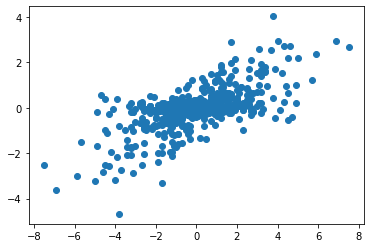

In [112]:
import matplotlib.pyplot as plt
plt.plot(df['DDG'],df['Pred_DDG'],'o')